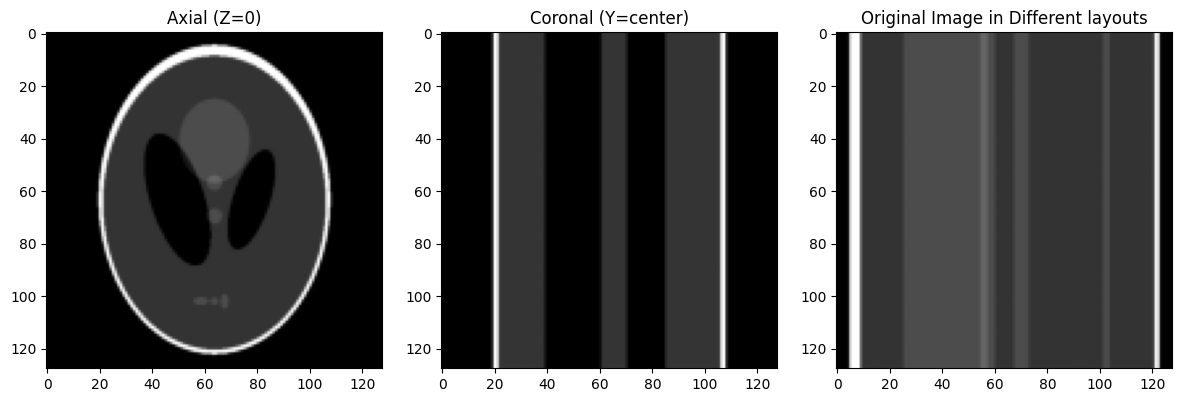

In [ ]:
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
import matplotlib.pyplot as plt

# --- Parameters ---
volume_size = 128  # Phantom will be volume_size^3

# --- Step 1: Generate a 2D Shepp-Logan phantom ---
phantom_2d = shepp_logan_phantom()  # Returns a 400x400 phantom
phantom_2d_resized = resize(phantom_2d, (volume_size, volume_size), mode='reflect', anti_aliasing=True)

# --- Step 2: Stack to create a 3D volume ---
phantom_3d = np.stack([phantom_2d_resized] * volume_size, axis=0)  # Shape: (Z, Y, X)

# --- Optional: visualize a few slices ---
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(phantom_3d[0], cmap='gray')
axs[0].set_title("Axial (Z=0)")
axs[1].imshow(phantom_3d[:, volume_size//2, :], cmap='gray')
axs[1].set_title("Coronal (Y=center)")
axs[2].imshow(phantom_3d[:, :, volume_size//2], cmap='gray')
axs[2].set_title("Sagittal (X=center)")
plt.tight_layout()
plt.show()

In [ ]:
pip install astra-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 121.3 MB/s eta 0:00:00


In [ ]:
import astra
import numpy as np

# --- Parameters ---
volume_size = 128  # Number of voxels in each dimension
detector_rows = 128  # vertical resolution of detector (Y-direction)
detector_cols = 256  # horizontal resolution of detector (X-direction)
num_angles = 360  # number of projections (views) around the object
radius = 200.0  # distance from source to rotation center
detector_spacing = 1.0  # spacing between detector pixels

# --- Step 1: Volume Geometry ---
vol_geom = astra.create_vol_geom(volume_size, volume_size, volume_size)

# --- Step 2: Define projection angles ---
angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)

# --- Step 3: Projection Geometry (Cone-Beam) ---
# source_origin: distance from source to origin (center of rotation)
# origin_detector: distance from origin to detector

source_origin = radius
origin_detector = radius

# This sets up a circular trajectory in the XY-plane.
proj_geom = astra.create_proj_geom(
    'cone',                  # Geometry type: cone-beam
    detector_spacing,        # Vertical detector spacing (row pitch)
    detector_spacing,        # Horizontal detector spacing (column pitch)
    detector_rows,           # Number of detector rows
    detector_cols,           # Number of detector columns
    angles,                  # Projection angles
    source_origin,           # Distance from source to rotation center
    origin_detector          # Distance from rotation center to detector
)

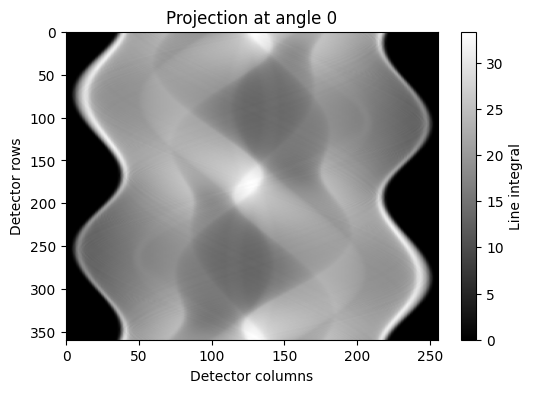

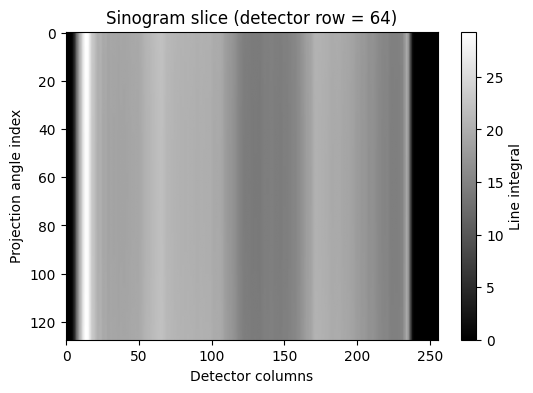

In [ ]:
import astra
import matplotlib.pyplot as plt

# --- Step 1: Create ASTRA 3D volume object from phantom_3d ---
vol_id = astra.data3d.create('-vol', vol_geom, data=phantom_3d)

# --- Step 2: Create 3D sinogram data object (projection data holder) ---
# This is where ASTRA will store the projection results
proj_id = astra.data3d.create('-sino', proj_geom)

# --- Step 3: Configure the forward projection algorithm ---
cfg = astra.astra_dict('FP3D_CUDA')  # GPU-based 3D forward projection
cfg['VolumeDataId'] = vol_id
cfg['ProjectionDataId'] = proj_id

# Create and run the algorithm
fp_id = astra.algorithm.create(cfg)
astra.algorithm.run(fp_id)

# --- Step 4: Retrieve the projection (sinogram) data ---
sinogram = astra.data3d.get(proj_id)  # Shape: (num_angles, detector_rows, detector_cols)

# --- Cleanup ---
#astra.algorithm.delete(fp_id)
#astra.data3d.delete(vol_id)
#astra.data3d.delete(proj_id)

# --- Choose slices for visualization of sinogram---
angle_index = 0  # First projection
row_index = detector_rows // 2  # Middle row of the detector

# --- 1. Plot a projection image at a given angle ---
plt.figure(figsize=(6, 4))
plt.imshow(sinogram[angle_index], cmap='gray', aspect='auto')
plt.title(f"Projection at angle {angle_index}")
plt.xlabel("Detector columns")
plt.ylabel("Detector rows")
plt.colorbar(label='Line integral')
plt.show()

# --- 2. Plot a sinogram slice: sinogram[:, row_index, :] ---
plt.figure(figsize=(6, 4))
plt.imshow(sinogram[:, row_index, :], cmap='gray', aspect='auto')
plt.title(f"Sinogram slice (detector row = {row_index})")
plt.xlabel("Detector columns")
plt.ylabel("Projection angle index")
plt.colorbar(label='Line integral')
plt.show()


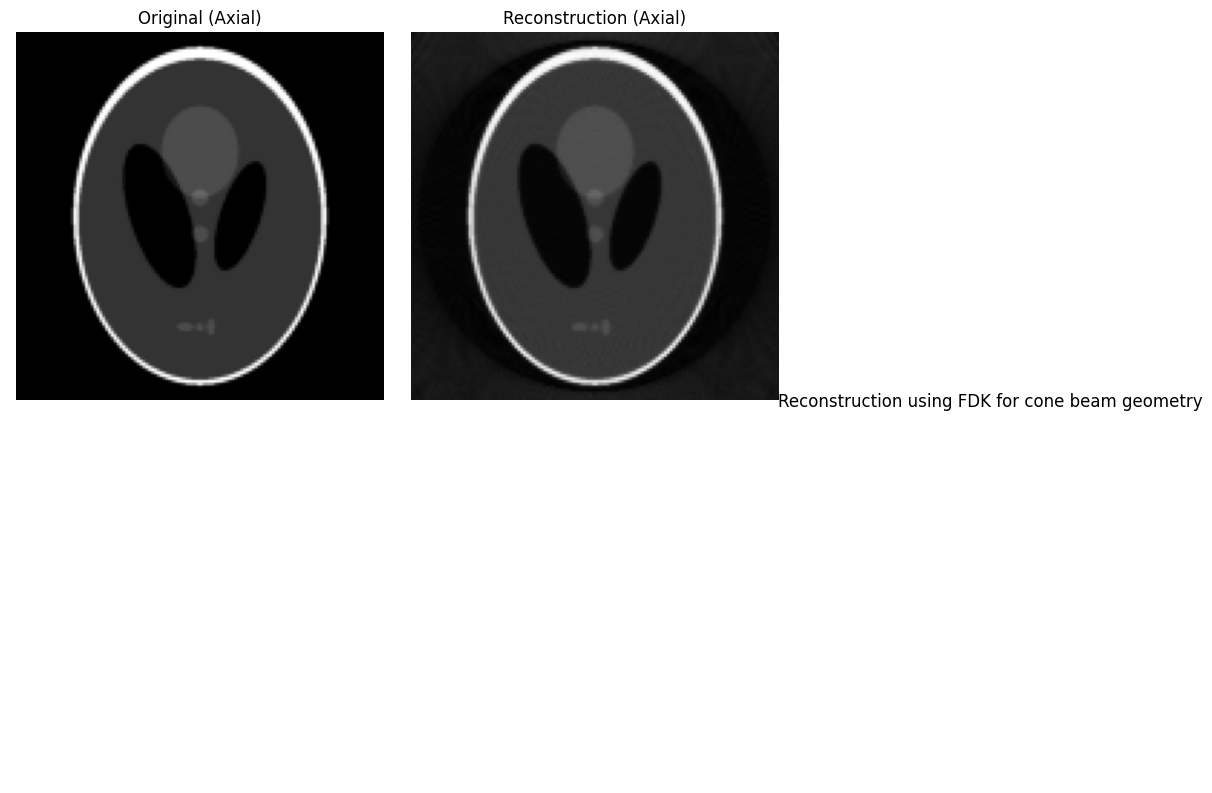

In [ ]:
# Step 1: Allocate memory for reconstructed volume
recon_id = astra.data3d.create('-vol', vol_geom)

# Step 2: Set up FDK algorithm using the sinogram
cfg = astra.astra_dict('FDK_CUDA')  # Use GPU-based Feldkamp algorithm
cfg['ReconstructionDataId'] = recon_id
cfg['ProjectionDataId'] = proj_id
cfg['ProjectorId'] = astra.create_projector('cuda3d', proj_geom, vol_geom)

# --- Step 3: Create and run the algorithm
fdk_id = astra.algorithm.create(cfg)
astra.algorithm.run(fdk_id)

# --- Step 4: Retrieve the reconstructed volume as a NumPy array ---
reconstruction_fdk_cone = astra.data3d.get(recon_id)

# --- Step 5: Visualization - show center slices for comparison ---
import matplotlib.pyplot as plt

z_slice = volume_size // 2  # Middle axial slice
y_slice = volume_size // 2  # Middle coronal slice
x_slice = volume_size // 2  # Middle sagittal slice

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# --- Original phantom ---
axs[0, 0].imshow(phantom_3d[z_slice], cmap='gray')
axs[0, 0].set_title('Original (Axial)')
#axs[0, 1].imshow(phantom_3d[:, y_slice, :], cmap='gray')
#axs[0, 1].set_title('Original (Coronal)')
#axs[0, 2].imshow(phantom_3d[:, :, x_slice], cmap='gray')
#axs[0, 2].set_title('Original (Sagittal)')

# --- Reconstructed volume ---
axs[0, 1].imshow(reconstruction_fdk_cone[z_slice], cmap='gray')
axs[0, 1].set_title('Reconstruction (Axial)')
#axs[1, 1].imshow(reconstruction[:, y_slice, :], cmap='gray')
#axs[1, 1].set_title('Reconstruction (Coronal)')
#axs[1, 2].imshow(reconstruction[:, :, x_slice], cmap='gray')
#axs[1, 2].set_title('Reconstruction (Sagittal)')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.title("Reconstruction using FDK for cone beam geometry")
plt.show()


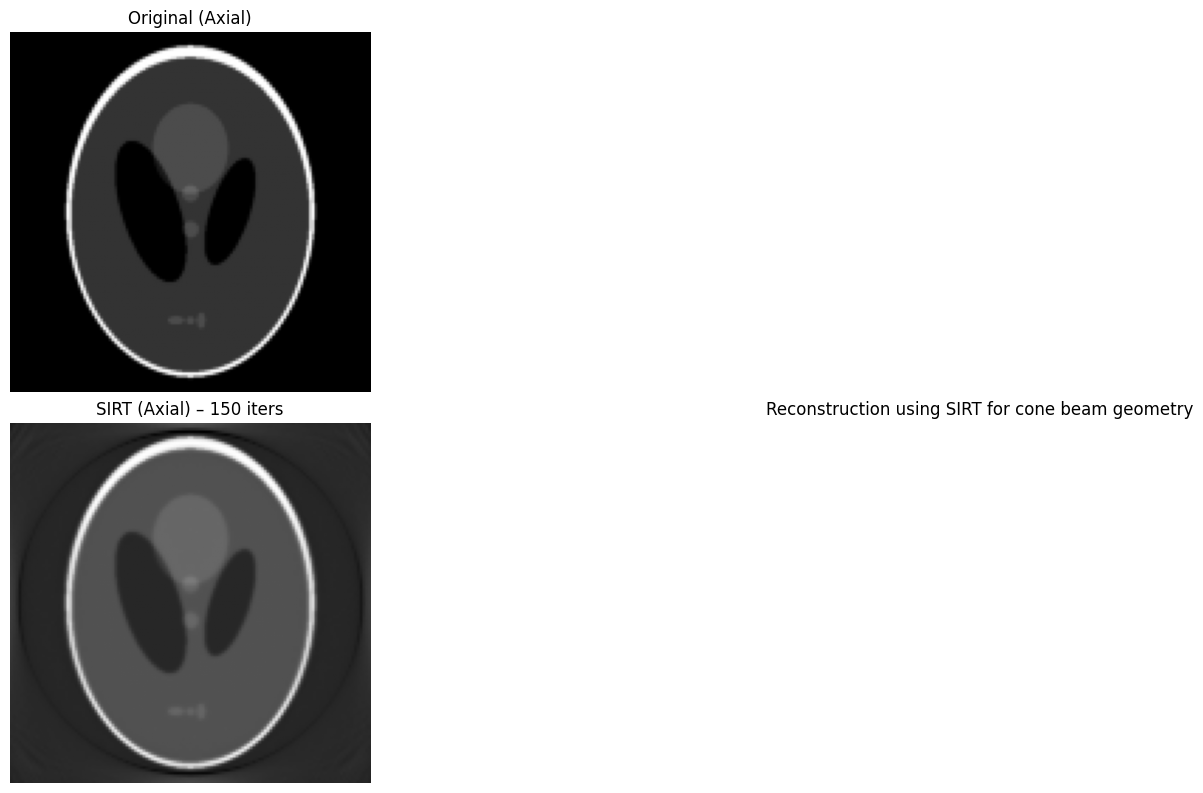

In [ ]:
#now we do the reconstruction using an iterative algorithm (SIRT)
# --- Step 1: Allocate memory for reconstructed volume ---
recon_id = astra.data3d.create('-vol', vol_geom)

# --- Step 2: Set up the SIRT algorithm ---
cfg = astra.astra_dict('SIRT3D_CUDA')  # GPU-based 3D SIRT algorithm
cfg['ReconstructionDataId'] = recon_id
cfg['ProjectionDataId'] = proj_id
cfg['ProjectorId'] = astra.create_projector('cuda3d', proj_geom, vol_geom)

# --- Step 3: Create and run the algorithm ---
sirt_id = astra.algorithm.create(cfg)

# Choose number of iterations
num_iterations = 150
astra.algorithm.run(sirt_id, num_iterations)

# --- Step 4: Retrieve the reconstructed volume ---
reconstruction_sirt_cone = astra.data3d.get(recon_id)

# --- Step 5: Visualization - show center slices for comparison ---
import matplotlib.pyplot as plt

z_slice = volume_size // 2
y_slice = volume_size // 2
x_slice = volume_size // 2

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# --- Original phantom ---
axs[0, 0].imshow(phantom_3d[z_slice], cmap='gray')
axs[0, 0].set_title('Original (Axial)')
#axs[0, 1].imshow(phantom_3d[:, y_slice, :], cmap='gray')
#axs[0, 1].set_title('Original (Coronal)')
#axs[0, 2].imshow(phantom_3d[:, :, x_slice], cmap='gray')
#axs[0, 2].set_title('Original (Sagittal)')

# --- Reconstructed volume ---
axs[1, 0].imshow(reconstruction_sirt_cone[z_slice], cmap='gray')
axs[1, 0].set_title(f'SIRT (Axial) – {num_iterations} iters')
#axs[1, 1].imshow(reconstruction[:, y_slice, :], cmap='gray')
#axs[1, 1].set_title('SIRT (Coronal)')
#axs[1, 2].imshow(reconstruction[:, :, x_slice], cmap='gray')
#axs[1, 2].set_title('SIRT (Sagittal)')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.title("Reconstruction using SIRT for cone beam geometry")
plt.show()


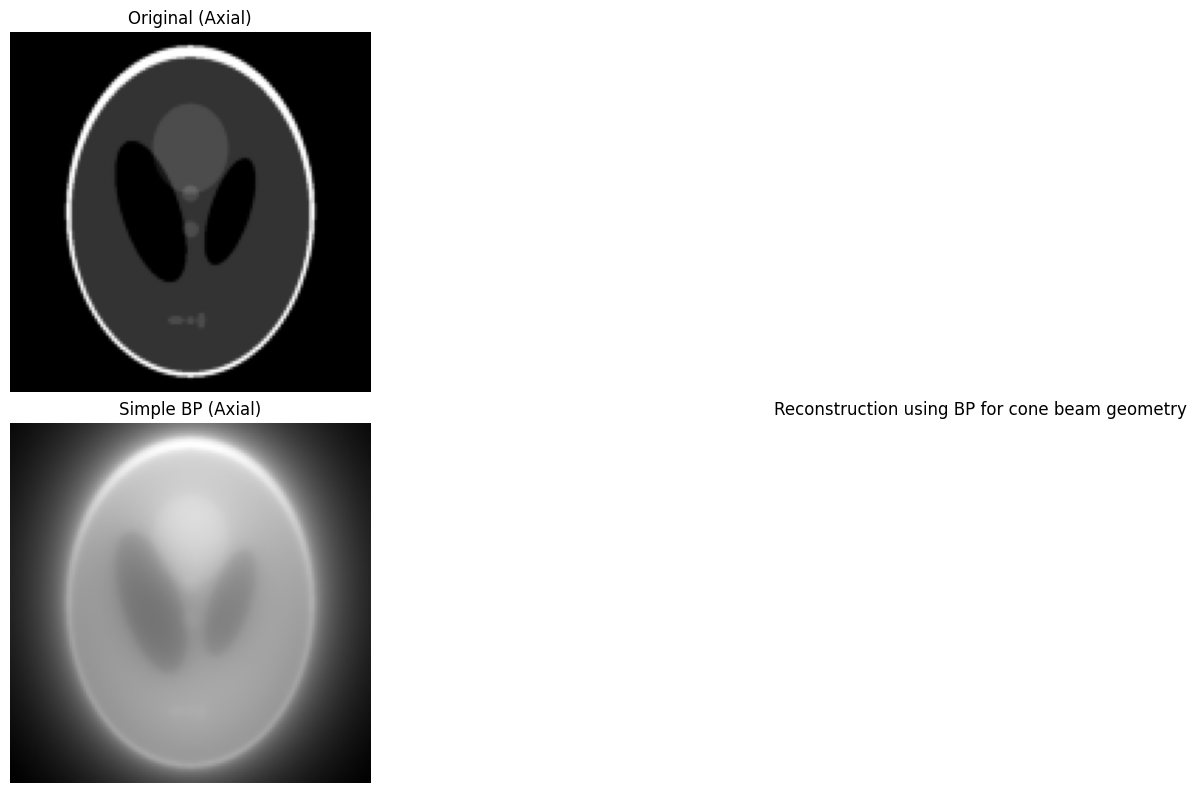

In [ ]:
# --- Step 1: Allocate memory for reconstructed volume ---
recon_id = astra.data3d.create('-vol', vol_geom)

# --- Step 2: Set up the CGLS algorithm ---
cfg = astra.astra_dict('BP3D_CUDA')  # GPU-based 3D CGLS algorithm
cfg['ReconstructionDataId'] = recon_id
cfg['ProjectionDataId'] = proj_id
#cfg['ProjectorId'] = astra.create_projector('cuda3d', proj_geom, vol_geom)

# --- Step 3: Create and run the algorithm ---
alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id)

# --- Step 4: Retrieve the reconstructed volume ---
reconstruction_bp_cone = astra.data3d.get(recon_id)

# --- Step 5: Visualization - show center slices for comparison ---
import matplotlib.pyplot as plt

z_slice = volume_size // 2
y_slice = volume_size // 2
x_slice = volume_size // 2

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Original phantom
axs[0, 0].imshow(phantom_3d[z_slice], cmap='gray')
axs[0, 0].set_title('Original (Axial)')
#axs[0, 1].imshow(phantom_3d[:, y_slice, :], cmap='gray')
#axs[0, 1].set_title('Original (Coronal)')
#axs[0, 2].imshow(phantom_3d[:, :, x_slice], cmap='gray')
#axs[0, 2].set_title('Original (Sagittal)')

# Reconstructed volume
axs[1, 0].imshow(reconstruction_bp_cone[z_slice], cmap='gray')
axs[1, 0].set_title('Simple BP (Axial)')
#axs[1, 1].imshow(reconstruction[:, y_slice, :], cmap='gray')
#axs[1, 1].set_title('CGLS (Coronal)')
#axs[1, 2].imshow(reconstruction[:, :, x_slice], cmap='gray')
#axs[1, 2].set_title('CGLS (Sagittal)')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.title("Reconstruction using BP for cone beam geometry")
plt.show()


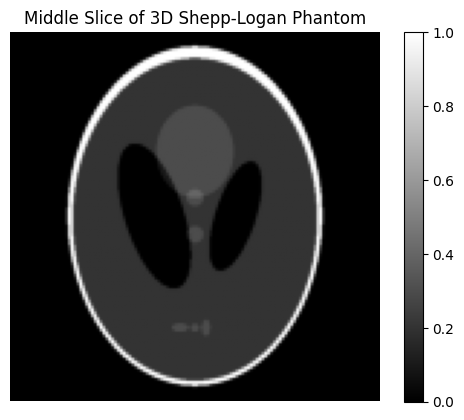

In [ ]:
#now we will perform back-projection on a parallel 3D geometry, with one direct algorithm and 2 iterative algorithms
#Constructing the 3d parallel image of the phantom
# Step 1: Define phantom volume size
nx, ny, nz = 128, 128, 128  # X, Y, Z dimensions of the 3D volume

# Step 2: Generate a single 2D Shepp-Logan phantom
phantom_2d = shepp_logan_phantom()  # Returns a 400x400 2D image by default

# Step 3: Resize to match desired 2D slice size
phantom_resized = resize(phantom_2d, (ny, nx), mode='reflect', anti_aliasing=True)

# Step 4: Stack the same 2D phantom along the Z-axis to build a 3D phantom
phantom_3d = np.stack([phantom_resized for _ in range(nz)], axis=0)  # shape = (nz, ny, nx)

# Step 5: Visualize one middle slice for confirmation
plt.imshow(phantom_3d[nz // 2], cmap='gray')
plt.title("Middle Slice of 3D Shepp-Logan Phantom")
plt.axis('off')
plt.colorbar()
plt.show()

In [ ]:
vol_geom = astra.create_vol_geom(nx, ny, nz) #define volume geometry
volume_size = 128  # Number of voxels in each dimension
detector_rows = 128  # vertical resolution of detector (Y-direction)
detector_cols = 128  # horizontal resolution of detector (X-direction)
detector_spacing = 1.0  # spacing between detector pixels
n_angles = 360
angles = np.linspace(0, 2 * np.pi, n_angles, endpoint=False)

# Step 4: Create the 3D parallel beam projection geometry
proj_geom = astra.create_proj_geom(
    'parallel3d',                  # Projection type: 3D parallel-beam
    detector_spacing, detector_spacing,  # Spacing between detector elements in Y and Z
    detector_rows, detector_cols,  # Number of detector rows and columns
    angles                          # List of projection angles (around the Z-axis)
)

# Step 5: Create a projector that links projection and volume geometries
projector_id = astra.create_projector('cuda3d', proj_geom, vol_geom)

In [ ]:
# Step 1: Create ASTRA volume data object from phantom_3d
vol_id = astra.data3d.create('-vol', vol_geom, phantom_3d)

# Step 2: Create ASTRA sinogram data object (empty)
sinogram_id = astra.data3d.create('-sino', proj_geom)

# Step 3: Set up forward projection algorithm (FP3D_CUDA)
cfg_fp = astra.astra_dict('FP3D_CUDA')
cfg_fp['VolumeDataId'] = vol_id
cfg_fp['ProjectionDataId'] = sinogram_id
cfg_fp['ProjectorId'] = projector_id

alg_id_fp = astra.algorithm.create(cfg_fp)

# Step 4: Run the forward projection
astra.algorithm.run(alg_id_fp)

# Step 5: Retrieve the simulated projection data (sinogram)
sinogram_data = astra.data3d.get(sinogram_id)

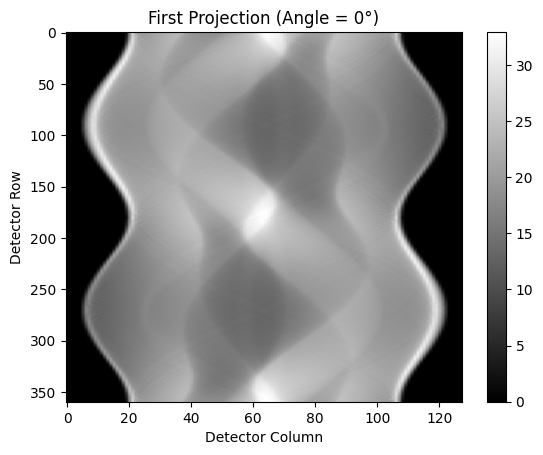

In [ ]:
#visualization of sinogram at a single angle
plt.imshow(sinogram_data[0], cmap='gray', aspect='auto')
plt.title("First Projection (Angle = 0°)")
plt.xlabel("Detector Column")
plt.ylabel("Detector Row")
plt.colorbar()
plt.show()

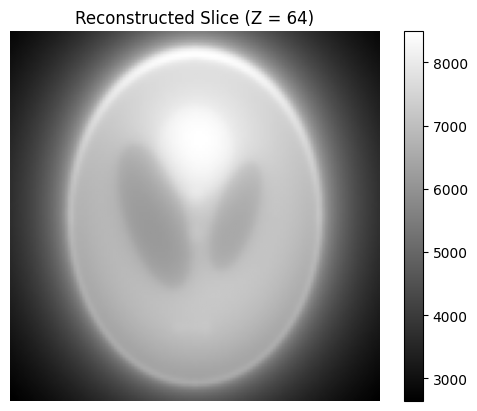

In [ ]:
# Step 1: Create an empty volume object for reconstruction
recon_id = astra.data3d.create('-vol', vol_geom)

# Step 2: Set up BP3D_CUDA algorithm configuration
cfg_bp = astra.astra_dict('BP3D_CUDA')
cfg_bp['ProjectionDataId'] = sinogram_id
cfg_bp['ReconstructionDataId'] = recon_id
cfg_bp['ProjectorId'] = projector_id

# Step 3: Create and run the algorithm
bp_id = astra.algorithm.create(cfg_bp)
astra.algorithm.run(bp_id)

# Step 4: Retrieve the reconstructed volume
reconstruction_bp_para = astra.data3d.get(recon_id)

# Step 5: Plot a central axial slice
import matplotlib.pyplot as plt

mid_slice = reconstruction_bp_para.shape[0] // 2
plt.imshow(reconstruction_bp_para[mid_slice], cmap='gray')
plt.title("Reconstruction using BP on parallel-3D")
plt.title(f'Reconstructed Slice (Z = {mid_slice})')
plt.axis('off')
plt.colorbar()
plt.show()

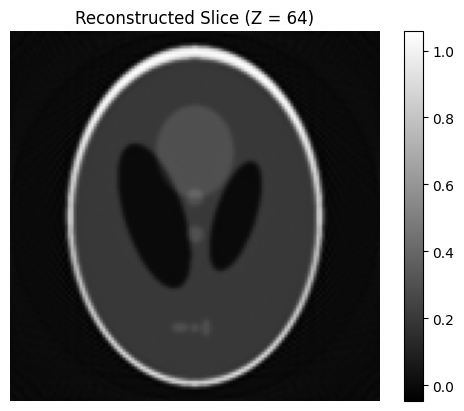

In [ ]:
# Step 1: Create an empty volume object for reconstruction
recon_id = astra.data3d.create('-vol', vol_geom)

# Step 2: Set up BP3D_CUDA algorithm configuration
cfg_bp = astra.astra_dict('SIRT3D_CUDA')
cfg_bp['ProjectionDataId'] = sinogram_id
cfg_bp['ReconstructionDataId'] = recon_id
cfg_bp['ProjectorId'] = projector_id

# Step 3: Create and run the algorithm
alg_id_bp = astra.algorithm.create(cfg_bp)
astra.algorithm.run(alg_id_bp, 150)

# Step 4: Retrieve the reconstructed volume
reconstruction_sirt_para = astra.data3d.get(recon_id)

# Step 5: Plot a central axial slice
import matplotlib.pyplot as plt

mid_slice = reconstruction_sirt_para.shape[0] // 2
plt.imshow(reconstruction_sirt_para[mid_slice], cmap='gray')
plt.title("Reconstruction using SIRT on parallel-3D")
plt.title(f'Reconstructed Slice (Z = {mid_slice})')
plt.axis('off')
plt.colorbar()
plt.show()

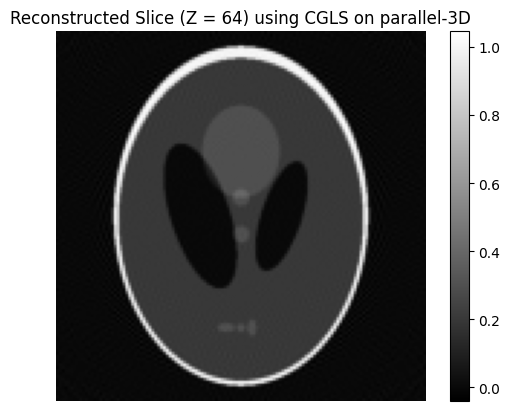

In [ ]:
# Step 1: Create an empty volume object for reconstruction
recon_id = astra.data3d.create('-vol', vol_geom)

# Step 2: Set up BP3D_CUDA algorithm configuration
cfg_bp = astra.astra_dict('CGLS3D_CUDA')
cfg_bp['ProjectionDataId'] = sinogram_id
cfg_bp['ReconstructionDataId'] = recon_id
cfg_bp['ProjectorId'] = projector_id

# Step 3: Create and run the algorithm
cgls_id = astra.algorithm.create(cfg_bp)
astra.algorithm.run(cgls_id, 150)

# Step 4: Retrieve the reconstructed volume
reconstruction_cgls_para = astra.data3d.get(recon_id)

# Step 5: Plot a central axial slice
import matplotlib.pyplot as plt

mid_slice = reconstruction_cgls_para.shape[0] // 2
plt.imshow(reconstruction_cgls_para[mid_slice], cmap='gray')
plt.title(f'Reconstructed Slice (Z = {mid_slice}) using CGLS on parallel-3D')
plt.axis('off')
plt.colorbar()
plt.show()

In [ ]:
from skimage.metrics import structural_similarity as ssim
import math

# Ensure both arrays are float32 and same shape
phantom_3d = phantom_3d.astype(np.float32)
reconstruction_bp_para = reconstruction_bp_para.astype(np.float32)

# 1. Mean Squared Error (MSE)
mse_bp_para = np.mean((phantom_3d - reconstruction_bp_para) ** 2)

# 2. Root Mean Squared Error (RMSE)
rmse_bp_para = np.sqrt(mse_bp_para)

# 3. Peak Signal-to-Noise Ratio (PSNR)
max_val = phantom_3d.max()
psnr = 20 * math.log10(max_val / rmse_bp_para) if rmse_bp_para != 0 else float('inf')

# 4. SSIM (slice-wise average)
ssim_vals = []
for z in range(phantom_3d.shape[0]):
    slice_ssim = ssim(phantom_3d[z], reconstruction_bp_para[z], data_range=phantom_3d[z].max() - phantom_3d[z].min())
    ssim_vals.append(slice_ssim)
avg_ssim = np.mean(ssim_vals)

# 5. Normalized RMSE (NRMSE)
nrmse = rmse_bp_para / np.linalg.norm(phantom_3d)

# 6. Mean Absolute Error (MAE)
mae = np.mean(np.abs(phantom_3d - reconstruction_bp_para))

# Print the results
print("Error metrics for BP using Parallel 3D geometry")
print(f"Mean Squared Error (MSE):        {mse_bp_para:.6f}")
print(f"Root Mean Squared Error (RMSE):  {rmse_bp_para:.6f}")
print(f"Normalized RMSE (NRMSE):         {nrmse:.6f}")
print(f"Peak Signal-to-Noise Ratio:      {psnr:.2f} dB")
print(f"Mean Absolute Error (MAE):       {mae:.6f}")
print(f"Average SSIM (slice-wise):       {avg_ssim:.6f}")

Error metrics for BP using Parallel 3D geometry
Mean Squared Error (MSE):        35406564.000000
Root Mean Squared Error (RMSE):  5950.341309
Normalized RMSE (NRMSE):         17.627285
Peak Signal-to-Noise Ratio:      -75.49 dB
Mean Absolute Error (MAE):       5737.401855
Average SSIM (slice-wise):       0.000000


In [ ]:
# Ensure both arrays are float32 and same shape
phantom_3d = phantom_3d.astype(np.float32)
reconstruction_bp_cone = reconstruction_bp_cone.astype(np.float32)

# 1. Mean Squared Error (MSE)
mse_bp_cone = np.mean((phantom_3d - reconstruction_bp_cone) ** 2)

# 2. Root Mean Squared Error (RMSE)
rmse_bp_cone = np.sqrt(mse_bp_cone)

# 3. Peak Signal-to-Noise Ratio (PSNR)
max_val = phantom_3d.max()
psnr = 20 * math.log10(max_val / rmse_bp_cone) if rmse_bp_cone != 0 else float('inf')

# 4. SSIM (slice-wise average)
ssim_vals = []
for z in range(phantom_3d.shape[0]):
    slice_ssim = ssim(phantom_3d[z], reconstruction_bp_cone[z], data_range=phantom_3d[z].max() - phantom_3d[z].min())
    ssim_vals.append(slice_ssim)
avg_ssim = np.mean(ssim_vals)

# 5. Normalized RMSE (NRMSE)
nrmse = rmse_bp_cone / np.linalg.norm(phantom_3d)

# 6. Mean Absolute Error (MAE)
mae = np.mean(np.abs(phantom_3d - reconstruction_bp_cone))

# Print the results
print("Error metrics for BP using cone beam geometry")
print(f"Mean Squared Error (MSE):        {mse_bp_cone:.6f}")
print(f"Root Mean Squared Error (RMSE):  {rmse_bp_cone:.6f}")
print(f"Normalized RMSE (NRMSE):         {nrmse:.6f}")
print(f"Peak Signal-to-Noise Ratio:      {psnr:.2f} dB")
print(f"Mean Absolute Error (MAE):       {mae:.6f}")
print(f"Average SSIM (slice-wise):       {avg_ssim:.6f}")

Error metrics for BP using cone beam geometry
Mean Squared Error (MSE):        284791200.000000
Root Mean Squared Error (RMSE):  16875.757812
Normalized RMSE (NRMSE):         49.992725
Peak Signal-to-Noise Ratio:      -84.55 dB
Mean Absolute Error (MAE):       11766.301758
Average SSIM (slice-wise):       0.136180


In [ ]:
# Ensure both arrays are float32 and same shape
phantom_3d = phantom_3d.astype(np.float32)
reconstruction_sirt_para = reconstruction_sirt_para.astype(np.float32)

# 1. Mean Squared Error (MSE)
mse_sirt_para= np.mean((phantom_3d - reconstruction_sirt_para) ** 2)

# 2. Root Mean Squared Error (RMSE)
rmse_sirt_para = np.sqrt(mse_sirt_para)

# 3. Peak Signal-to-Noise Ratio (PSNR)
max_val = phantom_3d.max()
psnr = 20 * math.log10(max_val / rmse_sirt_para) if rmse_sirt_para != 0 else float('inf')

# 4. SSIM (slice-wise average)
ssim_vals = []
for z in range(phantom_3d.shape[0]):
    slice_ssim = ssim(phantom_3d[z], reconstruction_sirt_para[z], data_range=phantom_3d[z].max() - phantom_3d[z].min())
    ssim_vals.append(slice_ssim)
avg_ssim = np.mean(ssim_vals)

# 5. Normalized RMSE (NRMSE)
nrmse = rmse_sirt_para / np.linalg.norm(phantom_3d)

# 6. Mean Absolute Error (MAE)
mae = np.mean(np.abs(phantom_3d - reconstruction_sirt_para))

# Print the results
print("Error metrics for SIRT using Parallel 3D geometry")
print(f"Mean Squared Error (MSE):        {mse_sirt_para:.6f}")
print(f"Root Mean Squared Error (RMSE):  {rmse_sirt_para:.6f}")
print(f"Normalized RMSE (NRMSE):         {nrmse:.6f}")
print(f"Peak Signal-to-Noise Ratio:      {psnr:.2f} dB")
print(f"Mean Absolute Error (MAE):       {mae:.6f}")
print(f"Average SSIM (slice-wise):       {avg_ssim:.6f}")

Error metrics for SIRT using Parallel 3D geometry
Mean Squared Error (MSE):        0.000830
Root Mean Squared Error (RMSE):  0.028804
Normalized RMSE (NRMSE):         0.000085
Peak Signal-to-Noise Ratio:      30.81 dB
Mean Absolute Error (MAE):       0.011951
Average SSIM (slice-wise):       0.950167


In [ ]:
# Ensure both arrays are float32 and same shape
phantom_3d = phantom_3d.astype(np.float32)
reconstruction_sirt_cone = reconstruction_sirt_cone.astype(np.float32)

# 1. Mean Squared Error (MSE)
mse_sirt_cone = np.mean((phantom_3d - reconstruction_sirt_cone) ** 2)

# 2. Root Mean Squared Error (RMSE)
rmse_sirt_cone = np.sqrt(mse_sirt_cone)

# 3. Peak Signal-to-Noise Ratio (PSNR)
max_val = phantom_3d.max()
psnr = 20 * math.log10(max_val / rmse_sirt_cone) if rmse_sirt_cone != 0 else float('inf')

# 4. SSIM (slice-wise average)
ssim_vals = []
for z in range(phantom_3d.shape[0]):
    slice_ssim = ssim(phantom_3d[z], reconstruction_sirt_cone[z], data_range=phantom_3d[z].max() - phantom_3d[z].min())
    ssim_vals.append(slice_ssim)
avg_ssim = np.mean(ssim_vals)

# 5. Normalized RMSE (NRMSE)
nrmse = rmse_sirt_cone / np.linalg.norm(phantom_3d)

# 6. Mean Absolute Error (MAE)
mae = np.mean(np.abs(phantom_3d - reconstruction_sirt_cone))

# Print the results
print("Error metrics for SIRT using Parallel 3D geometry")
print(f"Mean Squared Error (MSE):        {mse_sirt_cone:.6f}")
print(f"Root Mean Squared Error (RMSE):  {rmse_sirt_cone:.6f}")
print(f"Normalized RMSE (NRMSE):         {nrmse:.6f}")
print(f"Peak Signal-to-Noise Ratio:      {psnr:.2f} dB")
print(f"Mean Absolute Error (MAE):       {mae:.6f}")
print(f"Average SSIM (slice-wise):       {avg_ssim:.6f}")

Error metrics for SIRT using Parallel 3D geometry
Mean Squared Error (MSE):        0.025604
Root Mean Squared Error (RMSE):  0.160012
Normalized RMSE (NRMSE):         0.000474
Peak Signal-to-Noise Ratio:      15.92 dB
Mean Absolute Error (MAE):       0.072598
Average SSIM (slice-wise):       0.549374


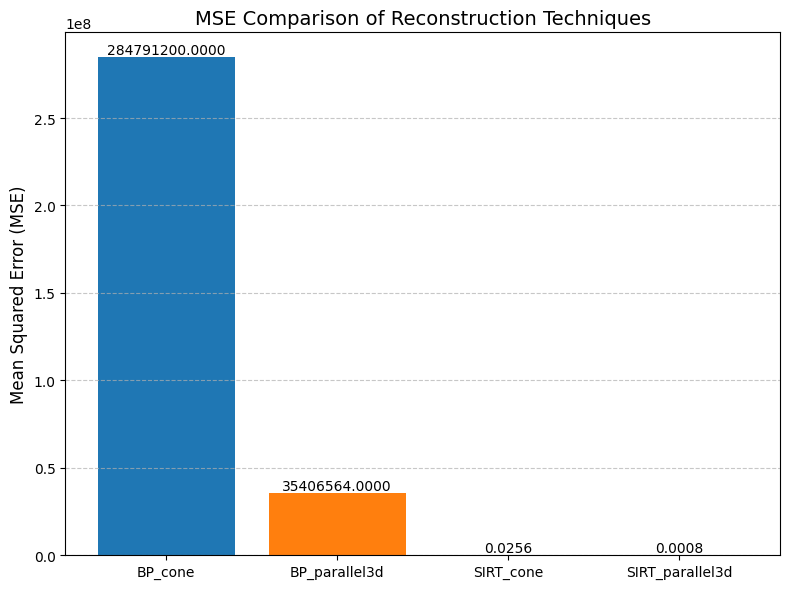

In [ ]:
# Technique names
techniques = ['BP_cone', 'BP_parallel3d', 'SIRT_cone', 'SIRT_parallel3d']

# MSE values (make sure these variables are defined earlier in your code)
MSEs = [mse_bp_cone, mse_bp_para, mse_sirt_cone, mse_sirt_para]

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(techniques, MSEs, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.001, f'{height:.4f}',
             ha='center', va='bottom', fontsize=10)

# Formatting
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.title('MSE Comparison of Reconstruction Techniques', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

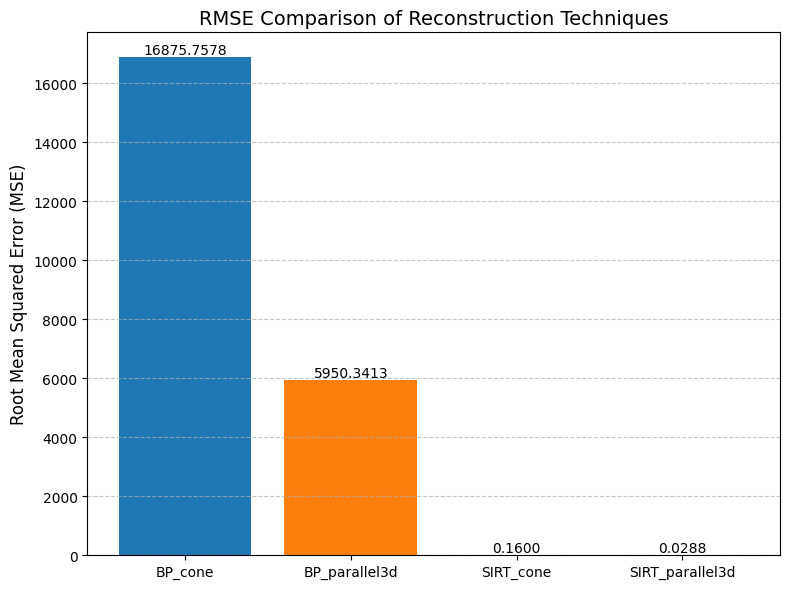

In [ ]:
# Technique names
techniques = ['BP_cone', 'BP_parallel3d', 'SIRT_cone', 'SIRT_parallel3d']

# MSE values (make sure these variables are defined earlier in your code)
RMSEs = [rmse_bp_cone, rmse_bp_para, rmse_sirt_cone, rmse_sirt_para]

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(techniques, RMSEs, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.001, f'{height:.4f}',
             ha='center', va='bottom', fontsize=10)

# Formatting
plt.ylabel('Root Mean Squared Error (MSE)', fontsize=12)
plt.title('RMSE Comparison of Reconstruction Techniques', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
#for seeing the variation of accuracy by varying the parameters for the apparatus, we create a function, which takes the following inputs:
#type of geometry (fanflat or parallel)
#technique used for reconstruction(should be in the astra toolbox documentation and compatible with the geometry type)
#number_of_angles
#number_of_detectors
#detector_spacing
#source_detector_dist
#source_center_dist
#image_resolution
def accuracy_predicter3d(type_of_geometry: str,
                       technique: str,
                       volume_size: int,
                       number_of_angles: int,
                       vertical_detector_spacing: float,
                       horizontal_detector_spacing: float,
                       detector_rows,
                       detector_columns,
                       source_center_dist= None,
                       center_detector_dist= None,
                       num_iterations= None
                       ) -> float:

                       #importing necessary libraries
                       import numpy as np
                       import matplotlib.pyplot as plt
                       from skimage.data import shepp_logan_phantom
                       import astra
                       from skimage.metrics import peak_signal_noise_ratio, structural_similarity

                       #creating image and projection object

                       # --- Step 1: Generate a 2D Shepp-Logan phantom ---
                       phantom_2d = shepp_logan_phantom()  # Returns a 400x400 phantom
                       phantom_2d_resized = resize(phantom_2d, (volume_size, volume_size), mode='reflect', anti_aliasing=True)
                       # --- Step 1: Volume Geometry ---
                       vol_geom = astra.create_vol_geom(volume_size, volume_size, volume_size)
                       # --- Step 2: Stack to create a 3D volume ---
                       phantom_3d = np.stack([phantom_2d_resized] * volume_size, axis=0)  # Shape: (Z, Y, X)
                       vol_id = astra.data3d.create('-vol', vol_geom, data=phantom_3d)
                       if type_of_geometry == 'parallel3d':
                        proj_geom = astra.create_proj_geom('parallel3d',# Projection type: 3D parallel-beam
                                                            vertical_detector_spacing,
                                                            horizontal_detector_spacing,  # Spacing between detector elements in Y and Z
                                                            detector_rows,
                                                            detector_cols,  # Number of detector rows and columns
                                                            np.linspace(0, 2*np.pi, number_of_angles, endpoint=False)
                                                           )
                       else:
                        proj_geom = astra.create_proj_geom('cone',
                                                           vertical_detector_spacing,
                                                           horizontal_detector_spacing,
                                                           detector_rows,
                                                           detector_cols,
                                                           np.linspace(0, 2*np.pi, number_of_angles, endpoint=False),
                                                           source_center_dist,
                                                           center_detector_dist
                                                           )

                       # --- Step 2: Create 3D sinogram data object (projection data holder) ---
                       # This is where ASTRA will store the projection results
                       projector_id = astra.create_projector('cuda3d', proj_geom, vol_geom)
                       proj_id = astra.data3d.create('-sino', proj_geom)


                       # --- Step 3: Configure the forward projection algorithm ---
                       cfg_fp = astra.astra_dict('FP3D_CUDA')  # GPU-based 3D forward projection
                       cfg_fp['VolumeDataId'] = vol_id
                       cfg_fp['ProjectionDataId'] = proj_id
                       cfg_fp['ProjectorId'] = projector_id

                       # Create and run the algorithm
                       alg_id_fp = astra.algorithm.create(cfg_fp)
                       astra.algorithm.run(alg_id_fp)
                       # --- Step 4: Retrieve the projection (sinogram) data ---
                       #sinogram = astra.data3d.get(proj_id)
                       # reconstruct
                       # initialize with ones to allow for multiplicative updates
                       recon_id = astra.data3d.create('-vol', vol_geom)
                       cfg = astra.astra_dict(technique)
                       cfg['ProjectionDataId'] = proj_id
                       cfg['ReconstructionDataId'] = recon_id
                       cfg['ProjectorId'] = projector_id

                       alg_id_recon = astra.algorithm.create(cfg)
                       if num_iterations is None:
                        astra.algorithm.run(alg_id_recon)
                       else:
                        astra.algorithm.run(alg_id_recon, num_iterations)
                       V = astra.data3d.get(recon_id)


                       mse = np.mean((V - phantom_3d)**2)

                       return mse

In [ ]:
x = accuracy_predicter3d('cone', 'SIRT3D_CUDA', 128, 360, 1.0, 1.0, 128, 256, 200, 300, 150)
print(x)

0.0372484010338025


In [ ]:
#on increasing:
#number of angles(projections): sparsity decreases: better accuracy
#number of detectors: sparsity decreases: better accuracy
#detector spacing: sparsity inceases: worse accuracy
#Image resolution: sparsity decreases: better accuracy
#source to center distance: sparsity decreases: better accuracy
#center to detector distance: sparsity increases: worse accuracy